In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install torch torchvision timm scikit-learn matplotlib seaborn --quiet

import os, time, json
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import numpy as np
import timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 104.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 102.2 MB/s eta 0:00:00


In [3]:
BASE_DIR      = '/content/drive/MyDrive/DatasetCombined'
train_dir     = os.path.join(BASE_DIR, 'train')
valid_dir     = os.path.join(BASE_DIR, 'valid')
test_dir      = os.path.join(BASE_DIR, 'test')

num_epochs    = 15
batch_size    = 32
learning_rate = 1e-3
momentum      = 0.9
weight_decay  = 1e-4
patience      = 4   # for scheduler & early stopping

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [4]:
splits = ['train','valid','test']
classes = ['FEMALE','MALE']
print("Image counts:")
for sp in splits:
    print(f"\n{sp.upper()}:")
    for c in classes:
        p = os.path.join(BASE_DIR, sp, c)
        cnt = sum(fname.lower().endswith(('.jpg','.png','.jpeg')) for fname in os.listdir(p))
        print(f"  {c}: {cnt}")
# Sample inspection
p0 = os.path.join(test_dir, classes[0])
f0 = [f for f in os.listdir(p0) if f.lower().endswith(('.jpg','.png'))][0]
img = Image.open(os.path.join(p0, f0))
print("\nSample TEST image → Mode:", img.mode, "Size:", img.size)

Image counts:

TRAIN:
  FEMALE: 915
  MALE: 954

VALID:
  FEMALE: 379
  MALE: 393

TEST:
  FEMALE: 54
  MALE: 55

Sample TEST image → Mode: RGB Size: (336, 256)


In [5]:
data_transforms = {
  'train': transforms.Compose([
     transforms.Resize((299,299)),
     transforms.RandomHorizontalFlip(),
     transforms.RandomRotation(15),
     transforms.ColorJitter(0.2,0.2,0.2),
     transforms.ToTensor(),
     transforms.Normalize([0.5]*3, [0.5]*3)
  ]),
  'valid': transforms.Compose([
     transforms.Resize((299,299)),
     transforms.ToTensor(),
     transforms.Normalize([0.5]*3, [0.5]*3)
  ]),
  'test': transforms.Compose([
     transforms.Resize((299,299)),
     transforms.ToTensor(),
     transforms.Normalize([0.5]*3, [0.5]*3)
  ]),
}

datasets_dict = {x: datasets.ImageFolder(os.path.join(BASE_DIR, x),
                      data_transforms[x]) for x in splits}
print('Classes:', datasets_dict['train'].classes)

dataloaders = {x: DataLoader(datasets_dict[x],
                    batch_size=batch_size,
                    shuffle=(x=='train'))
               for x in splits}

Classes: ['FEMALE', 'MALE']


In [6]:
# Load pretrained InceptionV3
model = timm.create_model('inception_v3', pretrained=True, num_classes=2)

# Freeze all layers up through Mixed_6e (approx features[:249])
for name, param in model.named_parameters():
    if 'Mixed_7' not in name and 'fc' not in name:
        param.requires_grad = False

# Identify layers
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total params: {total_params}, Trainable: {trainable_params}")

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()),
                      lr=learning_rate,
                      momentum=momentum,
                      weight_decay=weight_decay)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                    mode='min', factor=0.5, patience=patience, verbose=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/95.5M [00:00<?, ?B/s]

Total params: 21789666, Trainable: 12823810


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [7]:
best_val_acc, no_improve = 0.0, 0
train_losses, valid_losses = [], []
train_accs, valid_accs     = [], []

for epoch in range(num_epochs):
    start = time.time()
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    # Train
    model.train()
    running_loss, running_corrects = 0, 0
    for imgs, labels in dataloaders['train']:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = outputs.argmax(1)
        running_loss += loss.item()*imgs.size(0)
        running_corrects += (preds==labels).sum().item()
    ep_loss = running_loss/len(datasets_dict['train'])
    ep_acc  = running_corrects/len(datasets_dict['train'])
    train_losses.append(ep_loss); train_accs.append(ep_acc)
    print(f"  Train — loss: {ep_loss:.4f}, acc: {ep_acc:.4f}")

    # Validate
    model.eval()
    v_loss, v_corr = 0, 0
    with torch.no_grad():
        for imgs, labels in dataloaders['valid']:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            preds = outputs.argmax(1)
            v_loss += loss.item()*imgs.size(0)
            v_corr += (preds==labels).sum().item()
    val_loss = v_loss/len(datasets_dict['valid'])
    val_acc  = v_corr/len(datasets_dict['valid'])
    valid_losses.append(val_loss); valid_accs.append(val_acc)
    print(f"  Valid — loss: {val_loss:.4f}, acc: {val_acc:.4f}")

    # Scheduler & early stop
    scheduler.step(val_loss)
    if val_acc > best_val_acc:
        best_val_acc, no_improve = val_acc, 0
        torch.save(model.state_dict(), 'best_inception.pth')
    else:
        no_improve += 1
        if no_improve>=patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    print(f"  Time: {time.time()-start:.1f}s")


Epoch 1/15
  Train — loss: 0.4307, acc: 0.8577
  Valid — loss: 0.3609, acc: 0.8497
  Time: 1109.8s

Epoch 2/15
  Train — loss: 0.0952, acc: 0.9631
  Valid — loss: 0.2767, acc: 0.8964
  Time: 40.7s

Epoch 3/15
  Train — loss: 0.0617, acc: 0.9813
  Valid — loss: 0.3419, acc: 0.8756
  Time: 41.2s

Epoch 4/15
  Train — loss: 0.0506, acc: 0.9845
  Valid — loss: 0.3319, acc: 0.8925
  Time: 40.9s

Epoch 5/15
  Train — loss: 0.0435, acc: 0.9861
  Valid — loss: 0.2876, acc: 0.8912
  Time: 40.8s

Epoch 6/15
  Train — loss: 0.0340, acc: 0.9877
  Valid — loss: 0.2727, acc: 0.9028
  Time: 40.8s

Epoch 7/15
  Train — loss: 0.0284, acc: 0.9914
  Valid — loss: 0.3181, acc: 0.8912
  Time: 40.9s

Epoch 8/15
  Train — loss: 0.0244, acc: 0.9914
  Valid — loss: 0.3131, acc: 0.9028
  Time: 39.9s

Epoch 9/15
  Train — loss: 0.0287, acc: 0.9893
  Valid — loss: 0.3147, acc: 0.8977
  Time: 40.1s

Epoch 10/15
  Train — loss: 0.0315, acc: 0.9893
  Valid — loss: 0.3357, acc: 0.8912
Early stopping at epoch 10


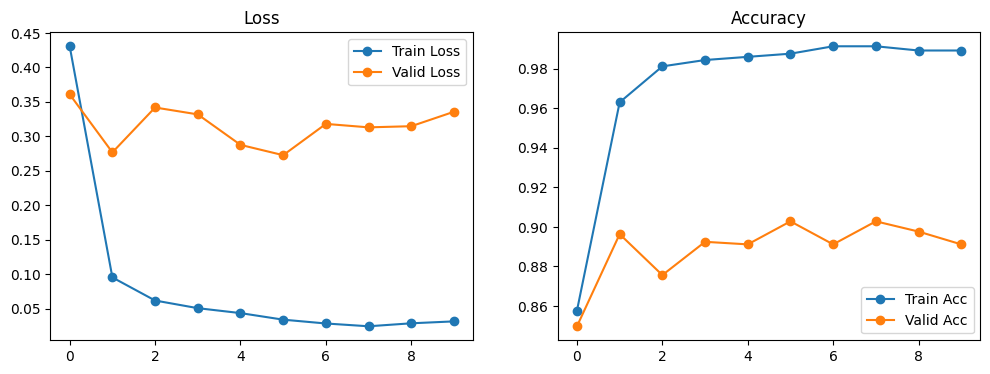

In [8]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(train_losses,'-o',label='Train Loss'); plt.plot(valid_losses,'-o',label='Valid Loss')
plt.title('Loss'); plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs,'-o',label='Train Acc'); plt.plot(valid_accs,'-o',label='Valid Acc')
plt.title('Accuracy'); plt.legend()
plt.show()

Confusion Matrix:
 [[47  7]
 [ 2 53]]

Report:
               precision    recall  f1-score   support

      FEMALE       0.96      0.87      0.91        54
        MALE       0.88      0.96      0.92        55

    accuracy                           0.92       109
   macro avg       0.92      0.92      0.92       109
weighted avg       0.92      0.92      0.92       109



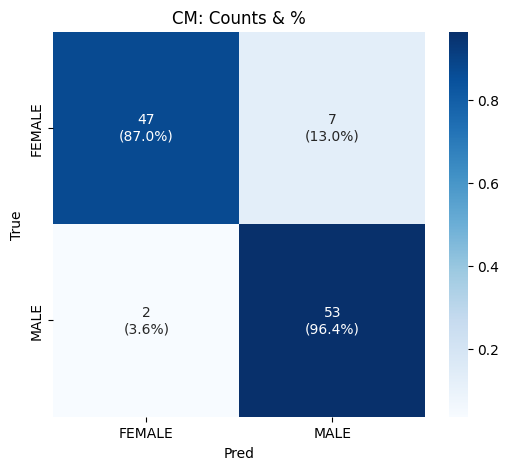

In [9]:
# Load best model
model.load_state_dict(torch.load('best_inception.pth'))
model.eval()

all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, labels in dataloaders['test']:
        imgs = imgs.to(device)
        out  = model(imgs)
        preds= out.argmax(1).cpu().tolist()
        all_preds += preds; all_labels += labels.tolist()

cm = confusion_matrix(all_labels, all_preds)
print('Confusion Matrix:\n', cm)
print('\nReport:\n', classification_report(all_labels, all_preds,
                                         target_names=classes))

# Percentage CM
cm_norm = cm.astype(float)/cm.sum(axis=1)[:,None]
annot = np.empty_like(cm).astype(str)
for i in range(cm.shape[0]):
  for j in range(cm.shape[1]):
    annot[i,j] = f"{cm[i,j]}\n({cm_norm[i,j]*100:.1f}%)"
plt.figure(figsize=(6,5))
sns.heatmap(cm_norm, annot=annot, fmt='', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Pred'); plt.ylabel('True')
plt.title('CM: Counts & %'); plt.show()

In [10]:
# Save Artifacts to Google Drive

from google.colab import drive
import json
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# a) Save best model weights
torch.save(model.state_dict(), '/content/drive/MyDrive/best_inceptionv3.pth')

# b) Save training history (losses & accuracies)
history = {
    'train_loss': train_losses,
    'valid_loss': valid_losses,
    'train_acc': train_accs,
    'valid_acc': valid_accs
}
with open('/content/drive/MyDrive/inceptionv3_history.json', 'w') as f:
    json.dump(history, f)

# c) Save loss & accuracy plots
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(train_losses, '-o', label='Train Loss')
plt.plot(valid_losses, '-o', label='Valid Loss')
plt.title('Loss per Epoch'); plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, '-o', label='Train Acc')
plt.plot(valid_accs, '-o', label='Valid Acc')
plt.title('Accuracy per Epoch'); plt.legend()

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/inceptionv3_training_curves.png')
plt.close()

# d) Save raw confusion matrix heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix (Counts)')
plt.savefig('/content/drive/MyDrive/inceptionv3_confusion_matrix.png')
plt.close()

# e) Save percentage confusion matrix heatmap
cm_norm = cm.astype(float) / cm.sum(axis=1)[:, None]
annot = np.empty_like(cm).astype(str)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        annot[i,j] = f"{cm[i,j]}\n({cm_norm[i,j]*100:.1f}%)"

plt.figure(figsize=(6,5))
sns.heatmap(cm_norm, annot=annot, fmt='', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix (Counts & %)')
plt.savefig('/content/drive/MyDrive/inceptionv3_confusion_matrix_pct.png')
plt.close()

# f) Save classification report as JSON
report = classification_report(all_labels, all_preds,
                               target_names=classes,
                               output_dict=True)
with open('/content/drive/MyDrive/inceptionv3_classification_report.json', 'w') as f:
    json.dump(report, f, indent=4)

print("✅ All InceptionV3 artifacts saved to Google Drive under MyDrive/")


✅ All InceptionV3 artifacts saved to Google Drive under MyDrive/
